In [1]:
import torch,math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F
import torch.nn as NN
torch.__version__

'1.5.0'

In [2]:
DATA_PATH=Path('./data/')

In [3]:
train = pd.read_csv(DATA_PATH / "fashion-mnist_train.csv");
train.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


In [4]:
test = pd.read_csv(DATA_PATH / "fashion-mnist_test.csv");
test.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,44,105,44,10,...,105,64,30,0,0,0,0,0,0,0
6,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,6,0,0,0,0,0,0,0,1,0,...,174,136,155,31,0,1,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,57,70,28,0,2,0,0,0,0,0


In [5]:
train.max()

label         9
pixel1       16
pixel2       36
pixel3      226
pixel4      164
           ... 
pixel780    255
pixel781    255
pixel782    255
pixel783    255
pixel784    170
Length: 785, dtype: int64

In [6]:
import struct
from PIL import Image 

with open(DATA_PATH / "train-images-idx3-ubyte", 'rb') as file_object:
    header_data=struct.unpack(">4I",file_object.read(16))
    print(header_data)

(2051, 60000, 28, 28)


In [7]:
with open(DATA_PATH / "train-labels-idx1-ubyte", 'rb') as file_object:
    header_data=struct.unpack(">2I",file_object.read(8))
    print(header_data)
(2049, 60000)

(2049, 60000)


(2049, 60000)

(28, 28)


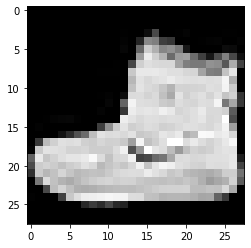

In [8]:
with open(DATA_PATH / "train-images-idx3-ubyte", 'rb') as file_object:
    raw_img=file_object.read()
img = struct.unpack_from(">784B",raw_img,16)
image = np.asarray(img)
image = image.reshape((28,28))
print(image.shape)
plt.imshow(image,cmap = plt.cm.gray)
plt.show()

In [9]:
with open(DATA_PATH / "train-labels-idx1-ubyte", 'rb') as file_object:
    raw_img = file_object.read(1)
    label = struct.unpack(">B",raw_img)
    print(label)

(0,)


In [10]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        data = pd.read_csv(csv_file)
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28).astype(float)
        self.Y = np.array(data.iloc[:, 0]);
        del data;  #结束data对数据的引用,节省空间
        self.len=len(self.X)

    def __len__(self):
        #return len(self.X)
        return self.len
        
    
    def __getitem__(self, idx):
        item = self.X[idx]
        label = self.Y[idx]
        return (item, label)

In [11]:
train_dataset = FashionMNISTDataset(csv_file=DATA_PATH / "fashion-mnist_train.csv")
test_dataset = FashionMNISTDataset(csv_file=DATA_PATH / "fashion-mnist_test.csv")

In [12]:
BATCH_SIZE=256

In [13]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

In [14]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=False)

In [15]:
a=iter(train_loader)
data=next(a)
img=data[0][0].reshape(28,28)
data[0][0].shape,img.shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]))

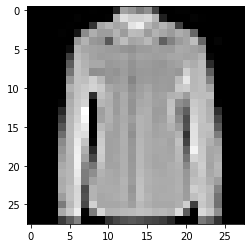

In [16]:
plt.imshow(img,cmap = plt.cm.gray)
plt.show()

In [17]:
class CNN(NN.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = NN.Sequential(   
            NN.Conv2d(1, 16, kernel_size=5, padding=2),
            NN.BatchNorm2d(16), 
            NN.ReLU()) #16, 28, 28
        self.pool1=NN.MaxPool2d(2) #16, 14, 14
        self.layer2 = NN.Sequential(
            NN.Conv2d(16, 32, kernel_size=3),
            NN.BatchNorm2d(32),
            NN.ReLU())#32, 12, 12
        self.layer3 = NN.Sequential(
            NN.Conv2d(32, 64, kernel_size=3),
            NN.BatchNorm2d(64),
            NN.ReLU()) #64, 10, 10
        self.pool2=NN.MaxPool2d(2)  #64, 5, 5
        self.fc = NN.Linear(5*5*64, 10)
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out=self.pool1(out)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out=self.layer3(out)
        #print(out.shape)
        out=self.pool2(out)
        #print(out.shape)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = self.fc(out)
        return out

In [18]:
cnn = CNN();
cnn(torch.rand(1,1,28,28))

tensor([[-0.0764, -0.1017, -1.5212,  0.2589,  0.8996,  0.2983,  0.1984,  0.6223,
         -1.2544, -0.7199]], grad_fn=<AddmmBackward>)

In [19]:
print(cnn)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1600, out_features=10, bias=True)
)


In [20]:
DEVICE=torch.device("cpu")
if torch.cuda.is_available():
        DEVICE=torch.device("cuda")
print(DEVICE)

cpu


In [21]:
cnn=cnn.to(DEVICE)

In [22]:
criterion = NN.CrossEntropyLoss().to(DEVICE)

In [23]:
LEARNING_RATE=0.01

In [24]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

In [25]:
TOTAL_EPOCHS=50

In [26]:
%%time
losses = [];
for epoch in range(TOTAL_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.float().to(DEVICE)
        labels = labels.to(DEVICE)
        #清零
        optimizer.zero_grad()
        outputs = cnn(images)
        #计算损失函数
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().data.item());
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f'%(epoch+1, TOTAL_EPOCHS, i+1, len(train_dataset)//BATCH_SIZE, loss.data.item()))

Epoch : 1/50, Iter : 100/234,  Loss: 0.4987
Epoch : 1/50, Iter : 200/234,  Loss: 0.3274
Epoch : 2/50, Iter : 100/234,  Loss: 0.2929
Epoch : 2/50, Iter : 200/234,  Loss: 0.3171
Epoch : 3/50, Iter : 100/234,  Loss: 0.2841
Epoch : 3/50, Iter : 200/234,  Loss: 0.2889
Epoch : 4/50, Iter : 100/234,  Loss: 0.3145
Epoch : 4/50, Iter : 200/234,  Loss: 0.2086
Epoch : 5/50, Iter : 100/234,  Loss: 0.2743
Epoch : 5/50, Iter : 200/234,  Loss: 0.2351
Epoch : 6/50, Iter : 100/234,  Loss: 0.1737
Epoch : 6/50, Iter : 200/234,  Loss: 0.2285
Epoch : 7/50, Iter : 100/234,  Loss: 0.2085
Epoch : 7/50, Iter : 200/234,  Loss: 0.1807
Epoch : 8/50, Iter : 100/234,  Loss: 0.2456
Epoch : 8/50, Iter : 200/234,  Loss: 0.2010
Epoch : 9/50, Iter : 100/234,  Loss: 0.2310
Epoch : 9/50, Iter : 200/234,  Loss: 0.1157
Epoch : 10/50, Iter : 100/234,  Loss: 0.2033
Epoch : 10/50, Iter : 200/234,  Loss: 0.1878
Epoch : 11/50, Iter : 100/234,  Loss: 0.1320


KeyboardInterrupt: 

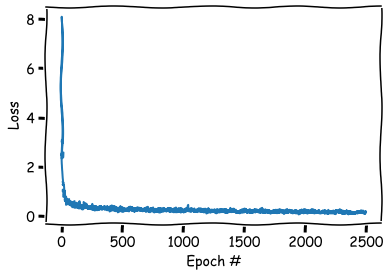

In [27]:
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses);
plt.show();

In [28]:
torch.save(cnn.state_dict(), "fm-cnn3.pth")

In [29]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = images.float().to(DEVICE)
    outputs = cnn(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('准确率: %.4f %%' % (100 * correct / total))

准确率: 91.0000 %


..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [30]:
%%time
#修改学习率和批次
cnn.train()
LEARNING_RATE=LEARNING_RATE / 10
TOTAL_EPOCHS=20
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
losses = [];
for epoch in range(TOTAL_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.float().to(DEVICE)
        labels = labels.to(DEVICE)
        #清零
        optimizer.zero_grad()
        outputs = cnn(images)
        #计算损失函数
        #损失函数直接放到CPU中，因为还有其他的计算
        loss = criterion(outputs, labels).cpu()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item());
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f'%(epoch+1, TOTAL_EPOCHS, i+1, len(train_dataset)//BATCH_SIZE, loss.data.item()))

KeyboardInterrupt: 

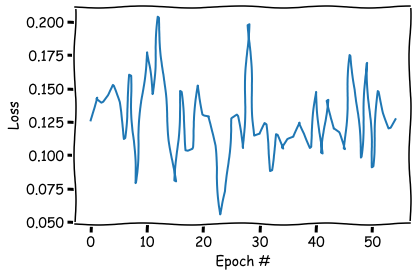

In [31]:
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses);
plt.show();

In [32]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = images.float().to(DEVICE)
    outputs = cnn(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('准确率: %.4f %%' % (100 * correct / total))

准确率: 92.0000 %


In [39]:
%%time
#修改学习率和批次
cnn.train()
LEARNING_RATE=LEARNING_RATE / 10
TOTAL_EPOCHS=10
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
losses = [];
for epoch in range(TOTAL_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.float().to(DEVICE)
        labels = labels.to(DEVICE)
        #清零
        optimizer.zero_grad()
        outputs = cnn(images)
        #计算损失函数
        #损失函数直接放到CPU中，因为还有其他的计算
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().data.item());
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f'%(epoch+1, TOTAL_EPOCHS, i+1, len(train_dataset)//BATCH_SIZE, loss.data.item()))

KeyboardInterrupt: 

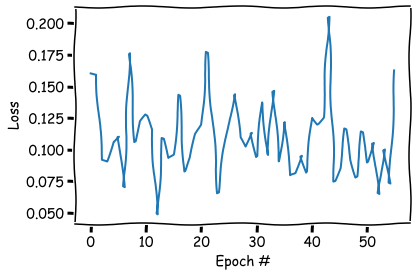

In [40]:
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses);
plt.show();

In [41]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = images.float().to(DEVICE)
    outputs = cnn(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('准确率: %.4f %%' % (100 * correct / total))

准确率: 92.0000 %
